## TODO List

#### Open Questions
- [ ] t-SNE with test or train samples?

#### Training
- [x] MLP 
- [ ] Different Models / Datasets
- [ ] CIPHAR 10 / 100
- [ ] ImageNet

#### Embedding Visualization
Data
- [x] PCA
- [ ] Use ALL train data for PCA?
- [x] t-SNE
- [ ] Visualize t-SNE training Steps
- [x] UMAP
- [x] UMAP Parameters
Visualization
- [ ] Live during training
- [ ] 3D
- [ ] With trajectory

#### Loss Landscape Visualization (later)
- [x] Get Code
- [ ] Classical Loss Landscape
- [ ] Topological Loss Landscape

# Visualizing Embedding Evolution During Training

In this notebook, we train an MLP on MNIST and visualize how hidden representations (embeddings) evolve over training using t-SNE. This gives insight into how class structure emerges in the latent space over time.

In [1]:
%matplotlib widget
# %load_ext autoreload
# %autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import random

# Reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # Bei Multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(torch.version.cuda)  # Should print something like '11.8'
print("Using device:", device)

2.6.0+cu124
12.4
Using device: cuda


# Dataset
### MNIST with MLP

In [2]:
from vision_classification import init_dataset

#dataset = "mnist"
dataset = "cifar10"
#dataset = "cifar100"

train_loader, test_loader, subset_loader = init_dataset(dataset, samples_per_class=100 if dataset != "cifar100" else 10)

50000 samples in train data
10000 samples in test data
1000 samples in visualization subset


In [3]:
from vision_classification import init_mlp_for_dataset, init_cnn_for_dataset, init_vit_for_dataset, init_resnet_for_dataset, init_densenet_for_dataset

#model = init_mlp_for_dataset(dataset, hidden_dims=[512, 254, 128], dropout=0.1).to(device)

#model = init_cnn_for_dataset(dataset, conv_dims=[64, 128, 256], kernel_sizes=[5, 3, 3], hidden_dims=[256, 128], dropout=0.2).to(device)
#model = init_cnn_for_dataset(dataset, conv_dims=[64, 128, 256, 512], kernel_sizes=[5, 3, 3, 3], hidden_dims=[512, 256], dropout=0.2).to(device)
#model = init_cnn_for_dataset(dataset, conv_dims=[128, 256, 512, 1024], kernel_sizes=[5, 3, 3, 3], hidden_dims=[1024, 256], dropout=0.2).to(device)

#model = init_vit_for_dataset(dataset, emb_dim=32, depth=4, num_heads=4, mlp_dim=128, dropout=0.15, patch_size=4).to(device)
#model = init_vit_for_dataset(dataset, emb_dim=64, depth=6, num_heads=8, mlp_dim=128, dropout=0.1, patch_size=7).to(device)

# model = init_vit_for_dataset(dataset, emb_dim=192, depth=6, num_heads=6, mlp_dim=256, dropout=0.1, patch_size=4).to(device) #CIFAR100
#model = init_vit_for_dataset(dataset, emb_dim=256, depth=12, num_heads=8, mlp_dim=512, dropout=0.15).to(device)

#model = init_resnet_for_dataset(dataset, fc_hidden_dims=[128], dropout=0.2).to(device)

model = init_densenet_for_dataset(dataset, fc_hidden_dims=[128], dropout=0.2).to(device)

# Model
### MLP

##### MNIST MLP Training
After 10 Epochs
| Embedding Dimension | Final Train Acc | Final Test Acc | Test Epoch 3 |
| ------------- | ------------- | ------------- | ------------- |
| 128 | 0.9897 | 0.9760 | 0.9610 |
| 64 | 0.9782 | **0.9706** | 0.9504 |
| 32 | 0.9678 | 0.9625 | 0.9428 |
| 16 | 0.9434 | 0.9398 | 0.9256 |

##### CIFAR10 ViT Training
After 20 Epochs
| Embedding / MLP Dimension | Depth, Heads | Regularization | Final Test Acc |
| ------------- | ------------- | ------------- | ------------- |
| 128/256 | 8, 4 | no | 0.6281 |
| 256/256 | 8, 4 | no | 0.6318 Ovf |
| 256/256 | 8, 4 | Dropout 0.1 | 0.6268 Ovf   |
| 128/256 | 8, 4 | Dropout 0.2 | 0.6163   |
| 128/128 | 8, 4 | Dropout 0.1 | 0.6311 end30+  |

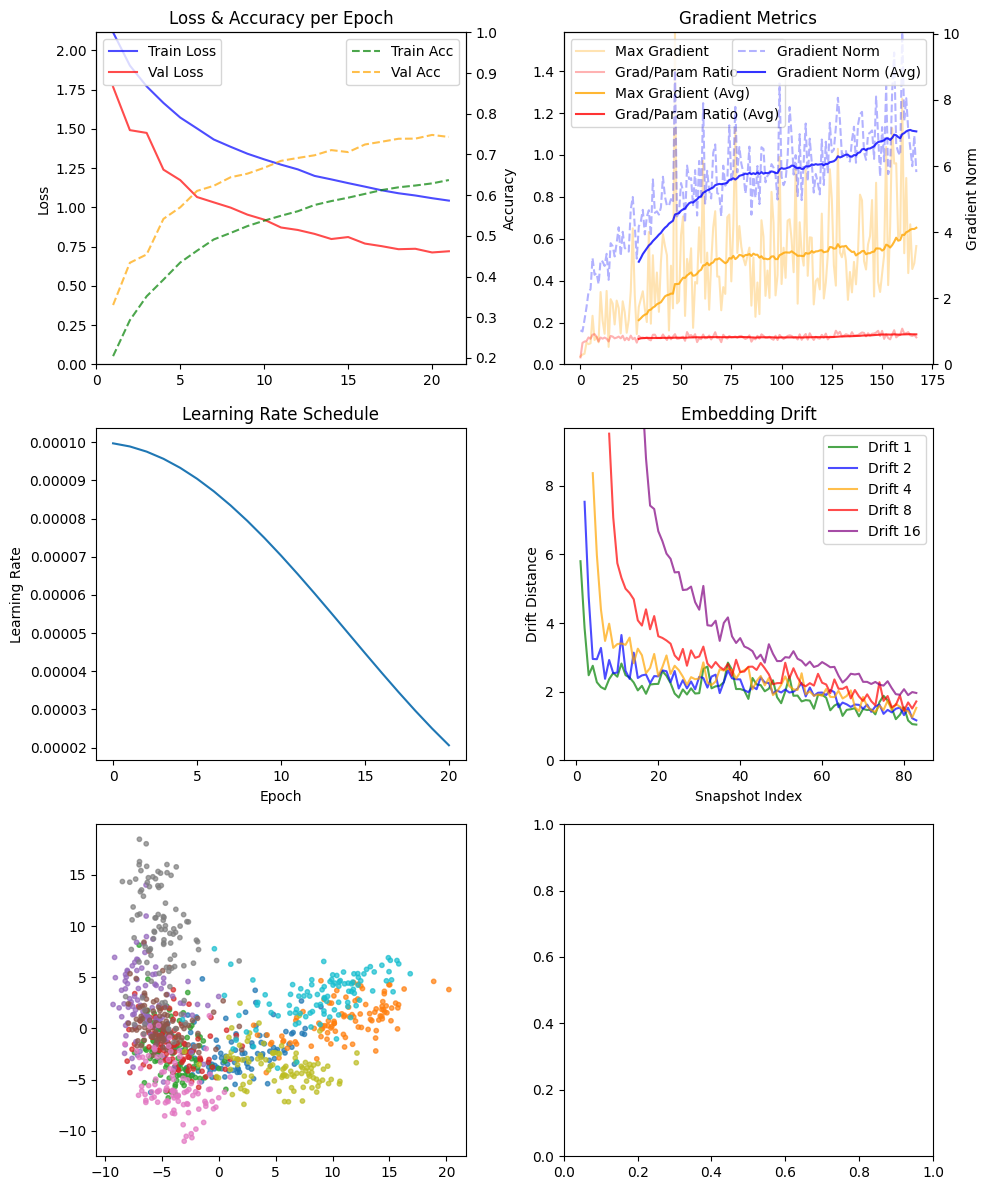

Epoch [1/30] | Train Loss: 2.1151, Acc: 0.2043 | Val Loss: 1.7680, Acc: 0.3299
Epoch [2/30] | Train Loss: 1.9037, Acc: 0.2926 | Val Loss: 1.4922, Acc: 0.4337
Epoch [3/30] | Train Loss: 1.7711, Acc: 0.3514 | Val Loss: 1.4746, Acc: 0.4542
Epoch [4/30] | Train Loss: 1.6655, Acc: 0.3923 | Val Loss: 1.2406, Acc: 0.5416
Epoch [5/30] | Train Loss: 1.5724, Acc: 0.4343 | Val Loss: 1.1740, Acc: 0.5700
Epoch [6/30] | Train Loss: 1.5029, Acc: 0.4634 | Val Loss: 1.0662, Acc: 0.6103
Epoch [7/30] | Train Loss: 1.4325, Acc: 0.4911 | Val Loss: 1.0323, Acc: 0.6229
Epoch [8/30] | Train Loss: 1.3861, Acc: 0.5070 | Val Loss: 0.9988, Acc: 0.6439
Epoch [9/30] | Train Loss: 1.3422, Acc: 0.5238 | Val Loss: 0.9541, Acc: 0.6527
Epoch [10/30] | Train Loss: 1.3061, Acc: 0.5372 | Val Loss: 0.9222, Acc: 0.6671
Epoch [11/30] | Train Loss: 1.2725, Acc: 0.5492 | Val Loss: 0.8723, Acc: 0.6842
Epoch [12/30] | Train Loss: 1.2424, Acc: 0.5603 | Val Loss: 0.8566, Acc: 0.6913
Epoch [13/30] | Train Loss: 1.2008, Acc: 0.5757 |

In [ ]:
%matplotlib inline

from train_viz import train_model_with_embedding_tracking

#optimizer = torch.optim.AdamW(model.parameters(), lr=0.001) #0.001
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

results = train_model_with_embedding_tracking(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    subset_loader=subset_loader, #test_subset
    num_classes=10 if "cifar100" != dataset else 100,
    device=device,
    epochs=30, #Max 50
    learning_rate=0.0001, # 0.0001
    dataset_name=dataset,
    embedding_records_per_epoch=4,
    track_embedding_drift=True,
    track_scheduled_lr=True,
    track_pca=True,
    #optimizer=optimizer,
    #scheduler=scheduler
)

##    return {
##        'train_losses': train_losses,
##        'val_losses': val_losses,
##        'train_accuracies': train_accuracies,
##        'val_accuracies': val_accuracies,
##        'subset_embeddings': test_subset_embeddings,
##        'subset_labels': test_subset_labels
##    }

In [ ]:
scheduler.__class__.__name__

### Embedding Drift
The embedding drift shows the Euclidean distance between the current embedding, compared to the snapshot of N (1 to 5) periods before.

It shows that the changes drop quickly, and that drifts measured over higher distances are in a similar range to distance 1.

In [ ]:
%matplotlib widget
from train_viz import _plot_embedding_drift

embedding_drifts = results["embedding_drifts"].copy()

fig, axs = plt.subplots(1, 1, figsize=(10, 4))

# Plot 2x Drifts
axs.plot(range(1, len(embedding_drifts[1]) + 1), np.array(embedding_drifts[1]) * 2, color="green", label="2x Drift 1", alpha=0.3)
axs.plot(range(1, len(embedding_drifts[2]) + 1), np.array(embedding_drifts[2]) * 2, color="blue", label="2x Drift 2", alpha=0.3)
axs.plot(range(1, len(embedding_drifts[4]) + 1), np.array(embedding_drifts[4]) * 2, color="orange", label="2x Drift 2", alpha=0.3)
axs.plot(range(1, len(embedding_drifts[8]) + 1), np.array(embedding_drifts[8]) * 2, color="red", label="2x Drift 2", alpha=0.3)

# Plot original drifts
_plot_embedding_drift(axs, embedding_drifts)

plt.legend()
plt.show()

# Video Animation
New

In [ ]:
from train_viz import generate_projections, animate_projections, show_with_slider, show_multiple_projections_with_slider, visualization_drift_vs_embedding_drift

In [ ]:
from data_manager import save_training_data

run = f"{dataset}_{model.__class__.__name__}_{model.emb_dim}_{max(results['val_accuracies']):.4f}"
save_training_data(run, results)
print(run)

## PCA

In [ ]:
projections_pca_first = generate_projections(
    embeddings_list=results["subset_embeddings"],
    method='pca',
    pca_fit_basis='first',
)
projections_pca_last = generate_projections(
    embeddings_list=results["subset_embeddings"],
    method='pca',
    pca_fit_basis='last',
)
projections_pca_all = generate_projections(
    embeddings_list=results["subset_embeddings"],
    method='pca',
    pca_fit_basis='all',
)

In [ ]:
print(len(results["subset_embeddings"]))
print(len(results["subset_labels"]))

print(len(results["subset_embeddings"][0]))
print(len(results["subset_labels"][0]))

In [ ]:
print(type(results["subset_labels"]))
print(type(results["subset_labels"][0]))

In [ ]:
%matplotlib widget

In [ ]:
show_multiple_projections_with_slider(
    projections_list=[projections_pca_first, projections_pca_last, projections_pca_all],
    labels=results["subset_labels"],
    titles=["PCA on first", "PCA on last", "PCA on all"],
    interpolate=False,
    steps_per_transition=5,
    figsize_per_plot=(4, 4),
)

In [ ]:
visualization_drift_vs_embedding_drift(projections_pca_all, embedding_drifts)

In [ ]:
from IPython.display import HTML
ani_pca = animate_projections(
    projections_pca_all,
    labels=results["subset_labels"],
    interpolate=False,
    steps_per_transition=5
)
HTML(ani_pca.to_jshtml())

## tSNE

In [ ]:
projections_tsne = generate_projections(
    embeddings_list=results["subset_embeddings"],
    method='tsne',
)

In [ ]:
ani_tsne = show_with_slider(
    projections_tsne,
    labels=results["subset_labels"],
    interpolate=False,
)

In [ ]:
visualization_drift_vs_embedding_drift(projections_tsne, embedding_drifts)

## t-SNE Backwards (reverse computation)

In [ ]:
projections_tsne_reverse = generate_projections(
    embeddings_list=results["subset_embeddings"],
    method='tsne',
    reverse_computation=True
)

In [ ]:
ani_tsne_reverse = show_with_slider(
    projections_tsne_reverse,
    labels=results["subset_labels"],
    interpolate=False,
)

In [ ]:
show_multiple_projections_with_slider(
    projections_list=[projections_tsne, projections_tsne_reverse],
    labels=results["subset_labels"],
    titles=["t-SNE", "t-SNE backwards"],
    interpolate=True,
    steps_per_transition=5,
    figsize_per_plot=(5, 5),
)

In [ ]:
visualization_drift_vs_embedding_drift(projections_tsne_reverse, embedding_drifts)

## t-SNE distance metric
euclidean vs cosine

In [ ]:
projections_tsne_cosine = generate_projections(
    embeddings_list=results["subset_embeddings"],
    method='tsne',
    metric='cosine'
)

In [ ]:
show_multiple_projections_with_slider(
    projections_list=[projections_tsne, projections_tsne_cosine],
    labels=results["subset_labels"],
    titles=["t-SNE", "t-SNE Cosine"],
    interpolate=True,
    steps_per_transition=5,
    figsize_per_plot=(5, 5),
)

## t-SNE Seeds

In [ ]:
projections_tsne_2 = generate_projections(
    embeddings_list=results["subset_embeddings"],
    method='tsne',
    random_state=1106,
    tsne_init='random'
)

In [ ]:
show_multiple_projections_with_slider(
    projections_list=[projections_tsne, projections_tsne_2, projections_tsne_reverse],
    labels=results["subset_labels"],
    titles=["t-SNE init with pca", "t-SNE init random", "t-SNE backwards"],
    steps_per_transition=5,
    figsize_per_plot=(4, 4),
)

## t-SNE Perplexity
Compare 5 - 10 - 30 - 50

In [ ]:
projections_tsne_p_5 = generate_projections(
    embeddings_list=results["subset_embeddings"],
    method='tsne',
    tsne_perplexity=5
)

projections_tsne_p_10 = generate_projections(
    embeddings_list=results["subset_embeddings"],
    method='tsne',
    tsne_perplexity=10
)

projections_tsne_p_50 = generate_projections(
    embeddings_list=results["subset_embeddings"],
    method='tsne',
    tsne_perplexity=50
)

In [ ]:
projections_tsne_p_30 = projections_tsne

In [ ]:
show_multiple_projections_with_slider(
    projections_list=[projections_tsne_p_5, projections_tsne_p_10, projections_tsne_p_30, projections_tsne_p_50],
    labels=results["subset_labels"],
    titles=["t-SNE Perplexity 5", "t-SNE Perplexity 10", "t-SNE Perpl. 30 (standard)", "t-SNE Perplexity 50"],
    interpolate=True,
    steps_per_transition=3,
    figsize_per_plot=(3.5, 3.5),
    dot_size=2,
    shared_axes=False
)

In [ ]:
visualization_drift_vs_embedding_drift(projections_tsne_p_5, embedding_drifts)

## t-SNE vs PCA

In [ ]:
show_multiple_projections_with_slider(
    projections_list=[projections_pca_all, projections_tsne],
    labels=results["subset_labels"],
    titles=["PCA on all", "t-SNE"],
    interpolate=True,
    steps_per_transition=10,
    figsize_per_plot=(5, 5),
    shared_axes=False,
)

In [ ]:
# ani_tsne = animate_projections(
#     projections_tsne,
#     labels=results["subset_labels"],
#     interpolate=True,
#     steps_per_transition=2
# )
# HTML(ani_tsne.to_jshtml())

## UMAP
UMAP (Uniform Manifold Approximation and Projection) is a **faster** alternative to t-SNE that also **aims to preserve some global structure**.

In [ ]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)

    projections_umap = generate_projections(
        embeddings_list=results["subset_embeddings"],
        method='umap',
        pca_fit_basis='last',
        umap_n_neighbors=15,
    )

In [ ]:
show_multiple_projections_with_slider(
    projections_list=[projections_umap, projections_tsne],
    labels=results["subset_labels"],
    titles=["UMAP", "t-SNE"],
    interpolate=False,
    steps_per_transition=10,
    figsize_per_plot=(5, 5),
    shared_axes=False,
)

In [ ]:
visualization_drift_vs_embedding_drift(projections_umap, embedding_drifts)

## UMAP Initialization
UMAP builds a graph-based representation of the data during `fit()`, learning the local and global structure (neighborhoods) in the `basis_data`. Once this structure is learned, it can be used to **transform new data** into the same low-dimensional space without retraining — unlike t-SNE, which must be refit every time.

This makes UMAP more efficient and suitable for dynamic or streaming embeddings.

IDEA: Fit not only on selection of test data?

In [ ]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)

    projections_umap_first = generate_projections(
        embeddings_list=results["subset_embeddings"],
        method='umap',
        pca_fit_basis='first',
        umap_n_neighbors=15,
    )

In [ ]:
# Todo: Middle
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)

    projections_umap_middle = generate_projections(
        embeddings_list=results["subset_embeddings"],
        method='umap',
        pca_fit_basis=int(len(results["subset_embeddings"]) / 2),
        umap_n_neighbors=15,
    )

In [ ]:
show_multiple_projections_with_slider(
    projections_list=[projections_umap, projections_umap_first],
    labels=results["subset_labels"],
    titles=["UMAP", "UMAP on first"],
    interpolate=False,
    steps_per_transition=10,
    figsize_per_plot=(5, 5),
    shared_axes=False,
)

## UMAP Hyperparameters
#### Number of Neighbors
Controls balance between local vs. global structure. (low = local, high = global)

Usually `5`, `10`, **`15` (standard)**, `30`, `50`, `100`

In [ ]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)

    projections_umap_n_5 = generate_projections(
        embeddings_list=results["subset_embeddings"],
        method='umap',
        pca_fit_basis='last',
        umap_n_neighbors=5,
    )

    projections_umap_n_50 = generate_projections(
        embeddings_list=results["subset_embeddings"],
        method='umap',
        pca_fit_basis='last',
        umap_n_neighbors=50,
    )

    projections_umap_n_100 = generate_projections(
        embeddings_list=results["subset_embeddings"],
        method='umap',
        pca_fit_basis='last',
        umap_n_neighbors=100,
    )

In [ ]:
projections_umap_n_15 = projections_umap

In [ ]:
show_multiple_projections_with_slider(
    projections_list=[projections_umap_n_5, projections_umap_n_15, projections_umap_n_50, projections_umap_n_100],
    labels=results["subset_labels"],
    titles=["UMAP 5 Neighbors", "UMAP 15 Neighbors", "UMAP 50 Neighbors", "UMAP 100 Neighbors"],
    figsize_per_plot=(4, 4),
    dot_size=3,
    shared_axes=False,
)

In [ ]:
visualization_drift_vs_embedding_drift(projections_umap_n_5, embedding_drifts)

#### Min Distance
Controls how tightly UMAP packs points together in low-D space.
- Lower = tighter clusters, less overlap.
- Higher = looser structure, more space between points.

Try values: `0.01`, `0.05`, **`0.1`** (standard), `0.3`, `0.5`, 

In [ ]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)

    projections_umap_d_001 = generate_projections(
        embeddings_list=results["subset_embeddings"],
        method='umap',
        pca_fit_basis='last',
        umap_n_neighbors=15,
        umap_min_dist=0.01
    )

    projections_umap_d_01 = generate_projections(
        embeddings_list=results["subset_embeddings"],
        method='umap',
        pca_fit_basis='last',
        umap_n_neighbors=15,
        umap_min_dist=0.1
    )

    projections_umap_d_05 = generate_projections(
        embeddings_list=results["subset_embeddings"],
        method='umap',
        pca_fit_basis='last',
        umap_n_neighbors=15,
        umap_min_dist=0.5
    )

In [ ]:
show_multiple_projections_with_slider(
    projections_list=[projections_umap_d_001, projections_umap_d_01, projections_umap_d_05],
    labels=results["subset_labels"],
    titles=["UMAP min_dist 0.01", "UMAP min_dist 0.1", "UMAP min_dist 0.5"],
    steps_per_transition=3,
    figsize_per_plot=(4, 4),
    dot_size=2,
)

In [ ]:
visualization_drift_vs_embedding_drift(projections_umap_d_05, embedding_drifts)

In [ ]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)

    projections_umap_guess = generate_projections(
        embeddings_list=results["subset_embeddings"],
        method='umap',
        pca_fit_basis='last',
        umap_n_neighbors=100, # 100 makes more movement
        umap_min_dist=0.5 #0.5 makes larger clusters
    )

In [ ]:
show_with_slider(
    projections_umap_guess,
    labels=results["subset_labels"],
    interpolate=True,
)

In [ ]:
show_multiple_projections_with_slider(
    projections_list=[projections_umap, projections_umap_guess, projections_tsne],
    labels=results["subset_labels"],
    titles=["UMAP", "UMAP 2", "t-SNE"],
    interpolate=True,
    steps_per_transition=10,
    figsize_per_plot=(4, 4),
    shared_axes=False,
)

In [ ]:
show_multiple_projections_with_slider(
    projections_list=[projections_umap_n_100, projections_umap_guess, projections_umap_d_05],
    labels=results["subset_labels"],
    titles=["UMAP 100 Neighbors", "UMAP both", "UMAP min_dist 0.5"],
    interpolate=True,
    steps_per_transition=3,
    figsize_per_plot=(4, 4),
    dot_size=2,
)

In [ ]:
visualization_drift_vs_embedding_drift(projections_umap_guess, embedding_drifts)

# Embedding Trajectory Visualization

In [ ]:
%matplotlib widget
show_with_slider_and_trajectories(
    projections=projections_pca_all,
    labels=results["subset_labels"],
    interpolate=True,
    steps_per_transition=3,
    figsize=(5, 5),
    dot_size=5,
    trail_length=10,
    show_trajectories=True,
    point_stride=1,
    trail_filter='percentile',          # 'all', 'top_k', 'percentile'
    trail_filter_value=10        # top-k count or top-X% percentile
)

In [ ]:
%matplotlib widget
show_with_slider_and_trajectories(
    projections=projections_umap,
    labels=results["subset_labels"],
    interpolate=True,
    steps_per_transition=3,
    figsize=(5, 5),
    dot_size=5,
    trail_length=4,
    show_trajectories=True,
    point_stride=1,
    trail_filter='percentile',          # 'all', 'top_k', 'percentile'
    trail_filter_value=10        # top-k count or top-X% percentile
)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

def show_with_slider_and_trajectories(
    projections,
    labels,
    figsize=(5, 5),
    cmap='tab10',
    dot_size=5,
    alpha=0.5,
    interpolate=False,
    steps_per_transition=10,
    show_trajectories=True,
    trail_length=15,
    point_stride=1,
    trail_filter='all',          # 'all', 'top_k', 'percentile'
    trail_filter_value=50        # top-k count or top-X% percentile
):
    # Interpolation
    if interpolate:
        projections_interp = []
        for a, b in zip(projections[:-1], projections[1:]):
            for alpha_step in np.linspace(0, 1, steps_per_transition, endpoint=False):
                interp = (1 - alpha_step) * a + alpha_step * b
                projections_interp.append(interp)
        projections_interp.append(projections[-1])
    else:
        projections_interp = projections

    projections = np.array(projections_interp)
    n_frames, n_points, _ = projections.shape

    # Select points by stride
    indices = np.arange(0, n_points, point_stride)
    n_active = len(indices)

    # --- Compute total movement per point ---
    displacements = np.linalg.norm(np.diff(projections, axis=0), axis=2)
    total_movement = displacements.sum(axis=0)

    # Determine which points to show tails for
    if trail_filter == 'all':
        tail_indices = set(indices)
    elif trail_filter == 'top_k':
        sorted_indices = np.argsort(total_movement)[::-1]
        tail_indices = set(sorted_indices[:trail_filter_value])
    elif trail_filter == 'percentile':
        cutoff = np.percentile(total_movement, 100 - trail_filter_value)
        tail_indices = set(np.where(total_movement >= cutoff)[0])
    else:
        raise ValueError(f"Invalid trail_filter: {trail_filter}")

    # Setup figure
    fig, ax = plt.subplots(figsize=figsize)
    all_proj = np.concatenate(projections, axis=0)
    max_abs = np.max(np.abs(all_proj))
    ax.set_xlim(-max_abs, max_abs)
    ax.set_ylim(-max_abs, max_abs)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

    # Scatter
    scatter = ax.scatter([], [], c=[], s=dot_size, cmap=cmap, alpha=alpha, zorder=2)

    # Trails
    trail_lines = []
    if show_trajectories:
        for i in indices:
            segments = []
            if i in tail_indices:
                for _ in range(trail_length):
                    line, = ax.plot([], [], lw=1.0, alpha=0.0, color='gray', zorder=1)
                    segments.append(line)
            trail_lines.append(segments)

    # --- Update function ---
    def update(frame_idx):
        current_coords = projections[frame_idx][indices]
        current_labels = np.array(labels[0])[indices]
        scatter.set_offsets(current_coords)
        scatter.set_array(current_labels)

        if show_trajectories and frame_idx > 0:
            for i, point_idx in enumerate(indices):
                segments = trail_lines[i]
                if not segments:  # point wasn't selected for trail
                    continue
                for j in range(trail_length):
                    t = frame_idx - j - 1
                    if t < 0:
                        segments[j].set_alpha(0.0)
                        continue
                    p1 = projections[t, point_idx]
                    p2 = projections[t + 1, point_idx]
                    segments[j].set_data([p1[0], p2[0]], [p1[1], p2[1]])
                    
                    # Fade oldest segment the most
                    alpha = (trail_length - j) / trail_length * 0.5
                    segments[j].set_alpha(alpha)
                    
        fig.canvas.draw_idle()

    # --- Slider widgets ---
    slider = widgets.Play(min=0, max=n_frames - 1, step=1)
    slider_control = widgets.IntSlider(min=0, max=n_frames - 1, step=1)
    widgets.jslink((slider, 'value'), (slider_control, 'value'))

    out = widgets.interactive_output(update, {'frame_idx': slider_control})
    display(widgets.VBox([widgets.HBox([slider, slider_control]), out]))


# Video Export

In [ ]:
# === Save as MP4 (with ffmpeg) ===
model_name = model._get_name()
lr = learning_rate
base_name = f"tsne_{model_name}_e{epochs}_lr{lr:.0e}"
i = 1
while os.path.exists(f"{base_name}_{i:03}.mp4"):
    i += 1
filename = f"{base_name}_{i:03}.mp4"

ani.save(filename, writer='ffmpeg', dpi=150)
print(f"Saved animation as {filename}")

In [ ]:
import os

# === Define experiment info ===
model_name = model._get_name()
# Build a base name with settings
base_name = f"tsne_{model_name}_e{epochs}_lr{learning_rate:.0e}"  # e.g., tsne_MLP_e10_lr1e-03

# Auto-increment file index
i = 1
while os.path.exists(f"{base_name}_{i:03}.gif"):
    i += 1
filename = f"{base_name}_{i:03}.gif"

# Save the animation
ani.save(filename, writer='pillow')
print(f"Saved animation as {filename}")

# Video Animation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.manifold import TSNE
import os

# === Interpolation between t-SNE results ===
def interpolate_tsne(embeddings_list, steps=10):
    interpolated = []
    for a, b in zip(embeddings_list[:-1], embeddings_list[1:]):
        for alpha in np.linspace(0, 1, steps, endpoint=False):
            interp = (1 - alpha) * a + alpha * b
            interpolated.append(interp)
    interpolated.append(embeddings_list[-1])  # include final frame
    return interpolated

# === Compute t-SNE per epoch using selected_indices ===
tsne_results = []

# Epoch 0
tsne = TSNE(n_components=2, init='pca', random_state=42)
result = tsne.fit_transform(embeddings[0][selected_indices])
tsne_results.append(result)

# Subsequent epochs
for epoch in range(1, len(embeddings)):
    tsne = TSNE(n_components=2, init=tsne_results[-1], random_state=42)
    result = tsne.fit_transform(embeddings[epoch][selected_indices])
    tsne_results.append(result)

# === Interpolate between epochs ===
tsne_results_interp = interpolate_tsne(tsne_results, steps=5)

# === Animation setup ===
fig, ax = plt.subplots(figsize=(8, 8))
scatter = ax.scatter([], [], cmap='tab10', alpha=0.7)
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
title = ax.set_title('t-SNE Embedding Evolution')

def update(frame):
    scatter.set_offsets(tsne_results_interp[frame])
    scatter.set_array(sampled_labels)
    title.set_text(f't-SNE Embedding Evolution – Frame {frame + 1}')
    return scatter,

ani = animation.FuncAnimation(fig, update, frames=len(tsne_results_interp), interval=100, blit=True)

In [ ]:
from IPython.display import HTML
HTML(ani.to_jshtml())

In [ ]:
# === Save as MP4 (with ffmpeg) ===
model_name = model._get_name()
lr = learning_rate
base_name = f"tsne_{model_name}_e{epochs}_lr{lr:.0e}"
i = 1
while os.path.exists(f"{base_name}_{i:03}.mp4"):
    i += 1
filename = f"{base_name}_{i:03}.mp4"

ani.save(filename, writer='ffmpeg', dpi=150)
print(f"Saved animation as {filename}")